<a href="https://www.kaggle.com/code/kavishchaudhary1003/playground-s3-e9?scriptVersionId=121055048" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import KFold, RandomizedSearchCV, RepeatedKFold, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor, IsolationForest
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

import os
for dirname, _, filenames in os.walk('/kaggle/input/playground-series-s3e9'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/playground-series-s3e9/sample_submission.csv
/kaggle/input/playground-series-s3e9/train.csv
/kaggle/input/playground-series-s3e9/test.csv


# Competition Page
https://www.kaggle.com/competitions/playground-series-s3e9

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e9/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e9/test.csv')

### Checking for null and duplicates

In [ ]:
train.isna().sum()
train.duplicated().sum()

In [3]:
for i in train.columns:
    print(train[i].value_counts())

0       1
3602    1
3610    1
3609    1
3608    1
       ..
1801    1
1800    1
1799    1
1798    1
5406    1
Name: id, Length: 5407, dtype: int64
349.0    215
331.0    149
500.0    138
310.0    101
236.0    101
        ... 
154.4      1
155.1      1
151.6      1
331.4      1
185.7      1
Name: CementComponent, Length: 314, dtype: int64
0.0      3166
189.0     101
106.3      89
209.4      76
145.0      70
         ... 
119.0       1
239.6       1
17.2        1
117.5       1
94.0        1
Name: BlastFurnaceSlag, Length: 224, dtype: int64
0.0      3927
118.3      96
94.0       73
79.0       57
24.5       56
         ... 
160.9       1
200.1       1
175.2       1
91.7        1
115.0       1
Name: FlyAshComponent, Length: 177, dtype: int64
192.0    1196
185.7     391
228.0     254
186.0     233
203.5     171
         ... 
191.4       1
194.7       1
153.6       1
173.1       1
178.3       1
Name: WaterComponent, Length: 215, dtype: int64
0.0     3143
11.6     161
8.0      104
7.0      100


### Drop id from train and test set

In [4]:
train.drop(columns = ['id'], inplace = True)
test.set_index('id', inplace = True)

### Summary stats

In [5]:
train.describe()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
count,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000
mean,299.168189,58.610579,31.872795,185.076235,4.108441,992.000718,771.219974,51.751618,35.452071
std,105.537682,83.417801,54.605003,18.517583,5.692296,77.148010,78.725253,70.006975,16.401896
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,213.700000,0.000000,0.000000,175.100000,0.000000,938.200000,734.300000,7.000000,23.640000
50%,297.200000,0.000000,0.000000,187.400000,0.000000,978.000000,781.200000,28.000000,33.950000
75%,375.000000,122.600000,79.000000,192.000000,8.050000,1047.000000,821.000000,56.000000,45.850000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


### Co-relation map 

In [6]:
corr = train.corr()
corr.style.background_gradient(cmap = 'coolwarm')

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
CementComponent,1.000000,-0.366493,-0.300175,-0.013257,0.031064,0.051756,-0.342021,0.096401,0.158000
BlastFurnaceSlag,-0.366493,1.000000,-0.168852,0.045222,0.110017,-0.282500,-0.172138,-0.055200,0.057506
FlyAshComponent,-0.300175,-0.168852,1.000000,-0.356596,0.460729,-0.077742,0.114354,-0.131903,0.031606
WaterComponent,-0.013257,0.045222,-0.356596,1.000000,-0.652649,-0.062145,-0.347965,0.235572,-0.113678
SuperplasticizerComponent,0.031064,0.110017,0.460729,-0.652649,1.000000,-0.309127,0.170732,-0.168666,0.208249
CoarseAggregateComponent,0.051756,-0.282500,-0.077742,-0.062145,-0.309127,1.000000,-0.263621,-0.017923,-0.098410
FineAggregateComponent,-0.342021,-0.172138,0.114354,-0.347965,0.170732,-0.263621,1.000000,-0.110100,-0.073900
AgeInDays,0.096401,-0.055200,-0.131903,0.235572,-0.168666,-0.017923,-0.110100,1.000000,0.334204
Strength,0.158000,0.057506,0.031606,-0.113678,0.208249,-0.098410,-0.073900,0.334204,1.000000


### Plotting the predictor variables

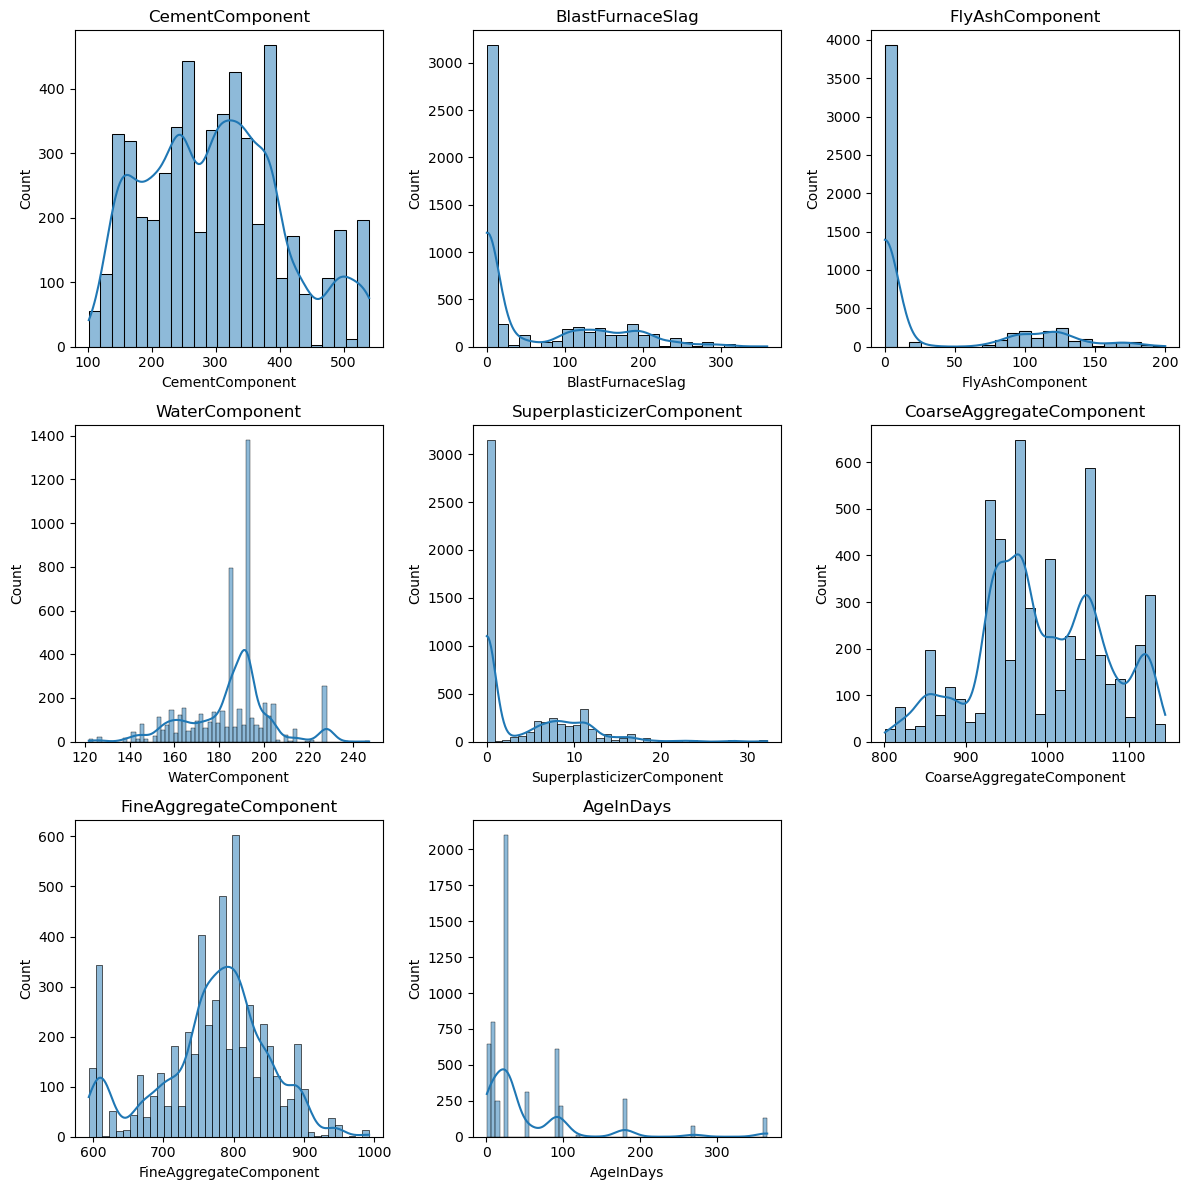

In [7]:
fig, axes = plt.subplots(ncols = 3, nrows = 3, figsize = (12,12))
for i, ax in enumerate(axes.flat):
    if i < len(['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent',
       'WaterComponent', 'SuperplasticizerComponent',
       'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays']):
        sns.histplot(x= train[(['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent',
       'WaterComponent', 'SuperplasticizerComponent',
       'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays'][i])], ax=ax, kde = True)
        ax.set_title(['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent',
       'WaterComponent', 'SuperplasticizerComponent',
       'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays'][i])   
    else:
        axes.flat[i].set_visible(False)
plt.tight_layout()
plt.show()

### Boxplot of predictor variables

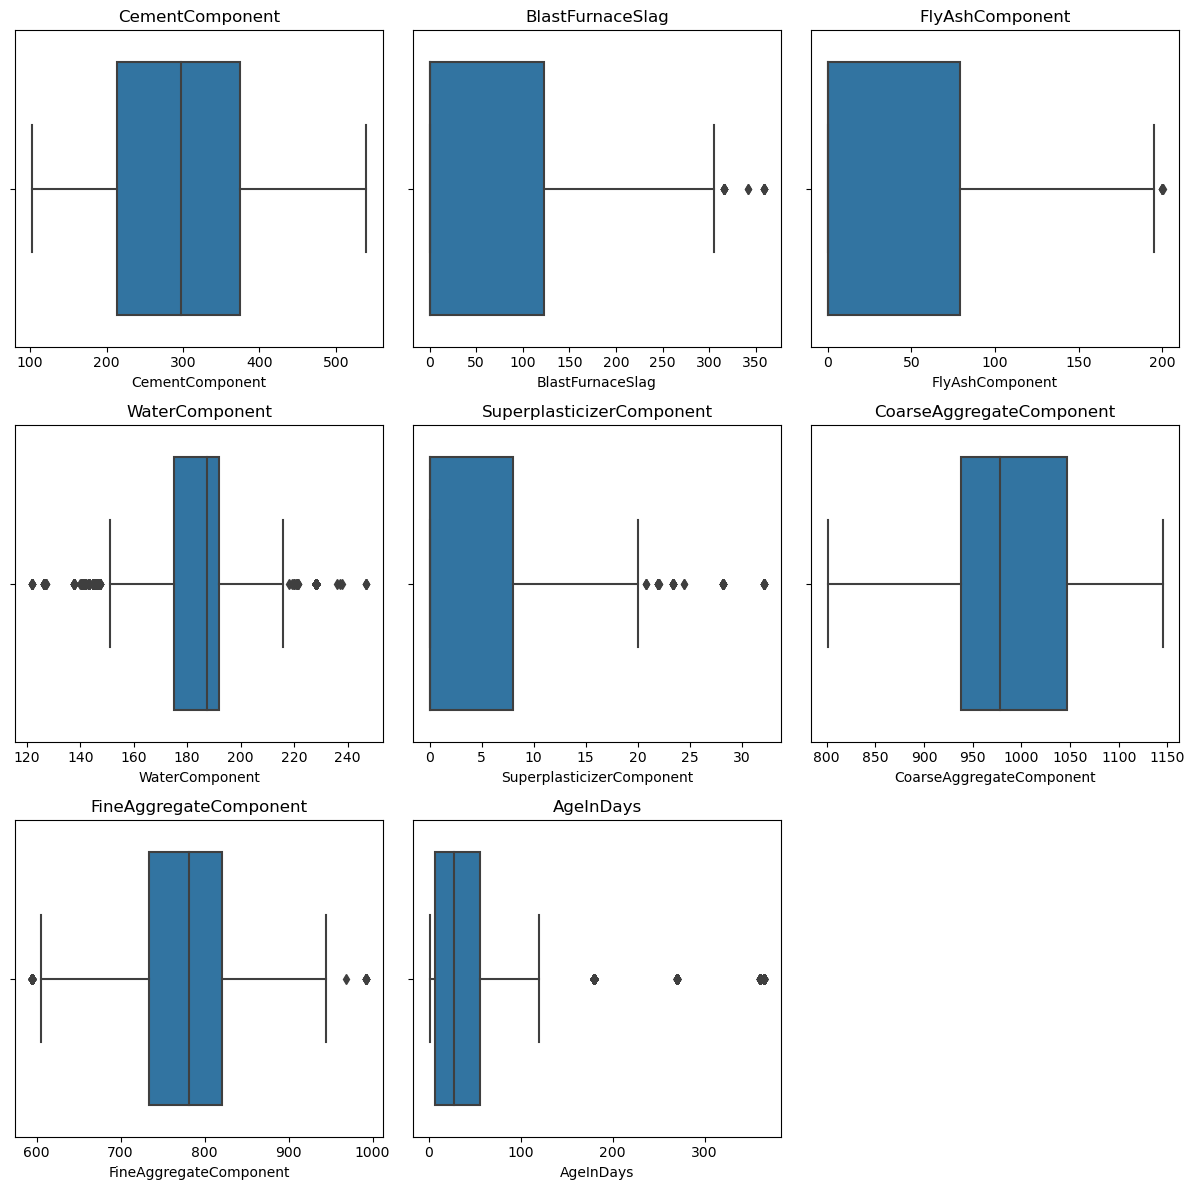

In [8]:
fig, axes = plt.subplots(ncols = 3, nrows = 3, figsize = (12,12))
for i, ax in enumerate(axes.flat):
    if i < len(['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent',
       'WaterComponent', 'SuperplasticizerComponent',
       'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays']):
        sns.boxplot(x = train[(['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent',
       'WaterComponent', 'SuperplasticizerComponent',
       'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays'][i])], ax = ax)
        ax.set_title(['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent',
       'WaterComponent', 'SuperplasticizerComponent',
       'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays'][i])
    else:
        axes.flat[i].set_visible(False)
plt.tight_layout()
plt.show()

### Plotting the target variable

<AxesSubplot:xlabel='Strength', ylabel='Count'>

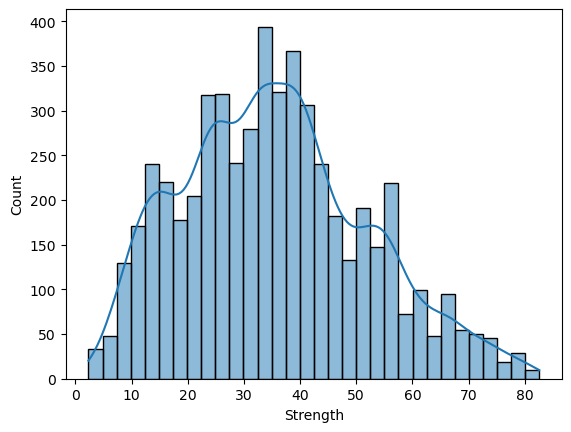

In [9]:
sns.histplot(x= train.Strength, kde = True)

### Separating features and target variable

In [10]:
y = train.Strength
train.drop(columns = ['Strength'], inplace = True)


### Standardizing the features

In [11]:
ss = StandardScaler()
train = pd.DataFrame(ss.fit_transform(train), columns = train.columns)
test = pd.DataFrame(ss.transform(test), columns = test.columns, index = test.index)

### Define a function for model evaluation

In [12]:
def model_eval(model, param, train, y):
    inner_cv = RepeatedKFold(n_splits = 10, n_repeats = 10, random_state = 0)
    outer_cv = RepeatedKFold(n_splits = 10, n_repeats = 10, random_state = 0)
    scores = []
    random = RandomizedSearchCV(model, param,cv = inner_cv, n_jobs = -1, scoring = 'neg_root_mean_squared_error', random_state = 0 )
    n_iter = random.n_iter
    with tqdm(total = n_iter) as pbar:
        for i in range(n_iter):
            random.set_params(n_iter =1)
            for train_index, test_index in outer_cv.split(train,y):
                trainx, testx = train.iloc[train_index], train.iloc[test_index]
                trainy, testy = y[train_index], y[test_index]
                random.fit(trainx, trainy)
                predy = random.best_estimator_.predict(testx)
                scores.append(mean_squared_error(testy, predy, squared = False))
            pbar.update()
    print(random.best_params_)
    print('Average RMSE', np.mean(scores))

### Decision Tree
### Randomizedsearch with nested cv
{'min_samples_split': 60, 'max_depth': 1, 'criterion': 'poisson'}

Average RMSE 16.37939137654078

In [ ]:
model = DecisionTreeRegressor()
param = {'min_samples_split': np.array(range(1,100)), 'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'max_depth' : np.array(range(1,10))}
model_eval(model, param, train, y)

In [ ]:
model = DecisionTreeRegressor(min_samples_split =60, max_depth = 1, criterion = 'poisson')
model.fit(train,y)

### Random Forest
### Randomizedsearch with nested cv


{'min_samples_split': 21, 'max_depth': 71, 'criterion': 'friedman_mse'}
Average RMSE 12.43909801776243

In [ ]:
model = RandomForestRegressor()
param = {'min_samples_split': np.array(range(1,100,10)), 'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'max_depth' : np.array(range(1,100,10))}
model_eval(model, param, train, y)

In [ ]:
model = RandomForestRegressor(min_samples_split =21, max_depth = 71, criterion = 'friedman_mse')
model.fit(train,y)

### XG Boost
### Nested cv
Average RMSE 12.939444556497563

In [13]:
model = XGBRegressor(objective='reg:squarederror',
                     eval_metric='rmse')
cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 0)
scores = []
for train_index, test_index in cv.split(train, y):
                trainx, testx = train.iloc[train_index], train.iloc[test_index]
                trainy, testy = y[train_index], y[test_index]
                model.fit(trainx, trainy)
                predy = model.predict(testx)
                scores.append(mean_squared_error(testy, predy, squared = False))
print('Average RMSE', np.mean(scores))

Average RMSE 12.939444556497563


### LGBM Regressor
### Nested CV
Average RMSE 12.382572627326569

In [15]:
model = LGBMRegressor(verbosity = -100)
cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 0)
scores = []
for train_index, test_index in cv.split(train, y):
                trainx, testx = train.iloc[train_index], train.iloc[test_index]
                trainy, testy = y[train_index], y[test_index]
                model.fit(trainx, trainy)
                predy = model.predict(testx)
                scores.append(mean_squared_error(testy, predy, squared = False))
print('Average RMSE', np.mean(scores))

Average RMSE 12.382572627326569


# The best model
### Cat Boost
### Nested CV
Average RMSE 12.338437402886335


In [16]:
model = CatBoostRegressor(verbose = 0)
cv = RepeatedKFold(n_splits = 10, n_repeats = 10, random_state = 0)
scores = []
for train_index, test_index in cv.split(train, y):
                trainx, testx = train.iloc[train_index], train.iloc[test_index]
                trainy, testy = y[train_index], y[test_index]
                model.fit(trainx, trainy)
                predy = model.predict(testx)
                scores.append(mean_squared_error(testy, predy, squared = False))
print('Average RMSE', np.mean(scores))

Average RMSE 12.338437402886335


In [ ]:
predictions = pd.DataFrame(model.predict(test), columns = ['Strength'], index = test.index)
predictions.to_csv('submission.csv', index = True)